In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product j.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_j= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_j.shape

(60, 1)

In [5]:
sales_j.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_j['Sales'].sum()

4532957

Text(0.5, 1.0, 'Product J')

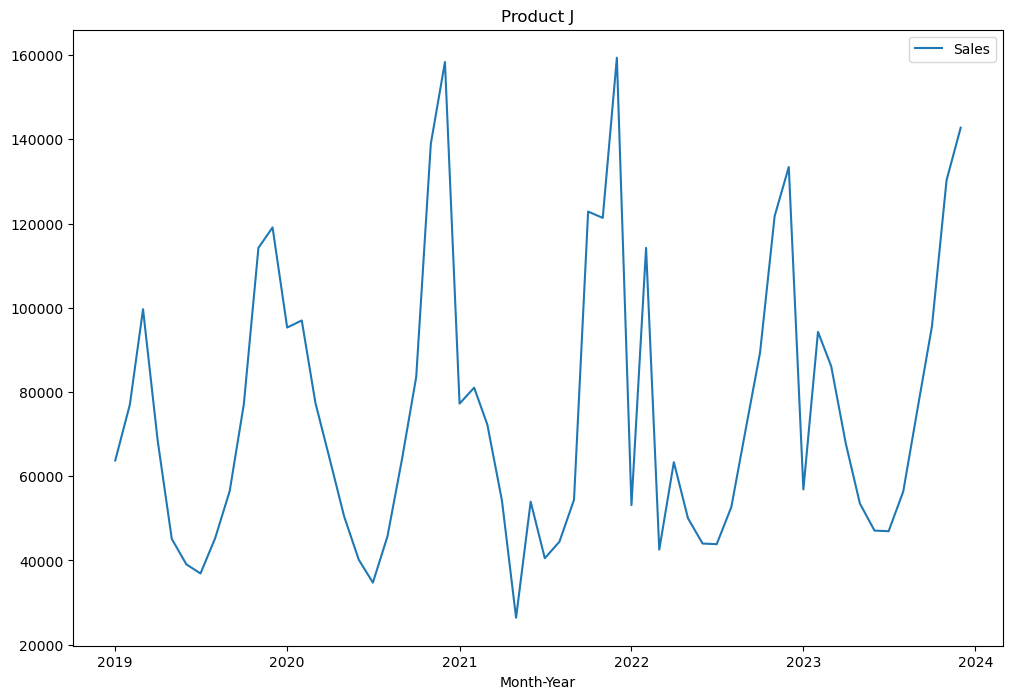

In [7]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_j)
plt.title('Product J')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_j)

ADF Statistics: -2.3759301997991913
p- value: 0.14864548261740318
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_j_diff= sales_j.diff().dropna()

Text(0.5, 1.0, 'Product J- First Difference')

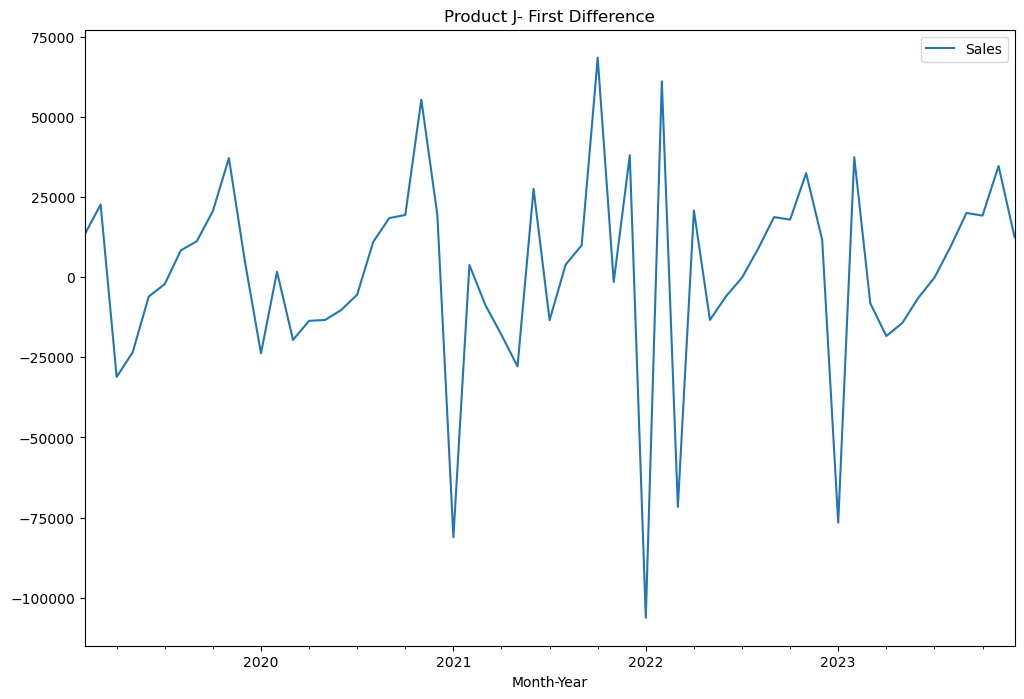

In [11]:
sales_j_diff.plot(figsize=(12,8))
plt.title('Product J- First Difference')

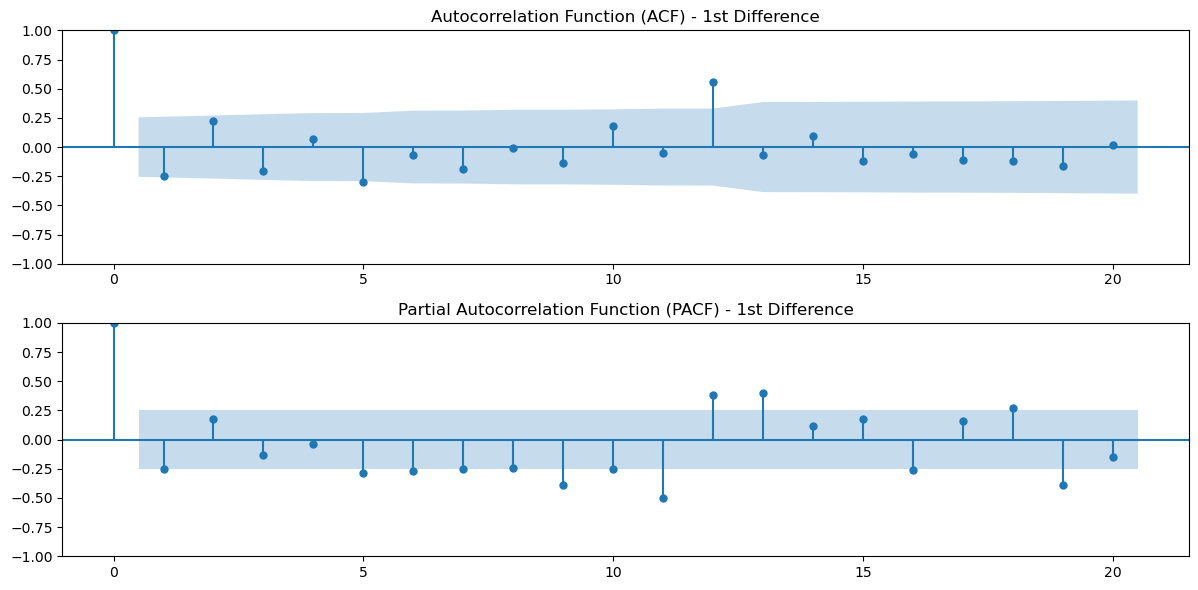

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_j_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_j_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_j_diff)

ADF Statistics: -6.410493361286657
p- value: 1.896152982571653e-08
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_j[:57]
test=sales_j[57:]

In [15]:
len(train)

57

In [16]:
#the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2,3) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(0,1,1),(0,1,2),(0,1,3),(1,1,0),(1,1,1),(1,1,2),(1,1,3),(2,1,0), (2,1,1), (2, 1, 2),(2,1,3),(3,1,0),(3,1,1),(3,1,2),(3,1,3),(4,1,0),(4,1,1),(4,1,2),(4,1,3),(5,1,0),(5,1,1),(5,1,2),(5,1,3)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_i, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_j)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
11  3  2  1306.887824  1319.039934  30900.230108  1.198301e+09  34616.487270
17  5  2  1308.170762  1324.373576  26805.512168  9.230892e+08  30382.382922
16  5  1  1310.927847  1325.105309  34371.668884  1.477653e+09  38440.256737
10  3  1  1311.631833  1321.758591  42050.064575  2.176077e+09  46648.444121
13  4  1  1313.081085  1325.233195  39098.646337  1.888668e+09  43458.807949
14  4  2  1314.245330  1328.422792  41730.585913  2.171570e+09  46600.108140
8   2  2  1315.334497  1325.461256  49241.785012  2.878196e+09  53648.822120
4   1  1  1318.807645  1324.883700  46766.594248  2.582908e+09  50822.322605
3   1  0  1319.789883  1323.840586  50713.478597  2.952128e+09  54333.491098
15  5  0  1320.138092  1332.290202  45340.946682  2.482176e+09  49821.443023
6   2  0  1320.211875  1326.287930  46825.155683  2.540313e+09  50401.516652
9   3  0  1320.583028  1328.684435  49236.998127  2.852177e+09  53405.781214

In [20]:
m_arima= ARIMA (train, order=(3,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   57
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -647.444
Date:                Thu, 09 May 2024   AIC                           1306.888
Time:                        18:58:18   BIC                           1319.040
Sample:                    01-01-2019   HQIC                          1311.599
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1447      0.190      6.023      0.000       0.772       1.517
ar.L2         -0.1082      0.279     -0.387      0.698      -0.656       0.439
ar.L3         -0.4178      0.180     -2.322      0.0

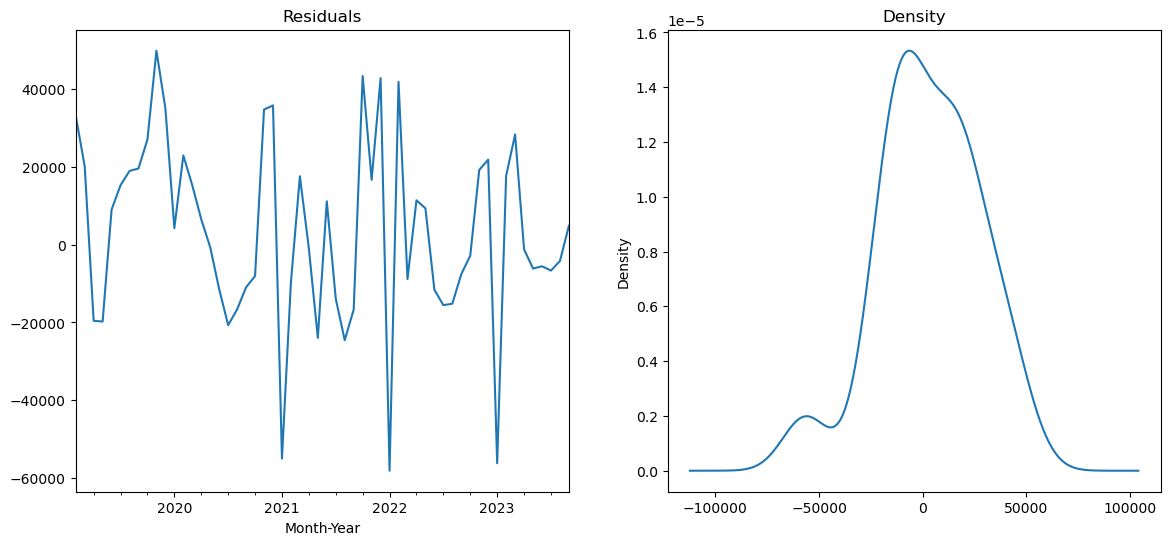

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

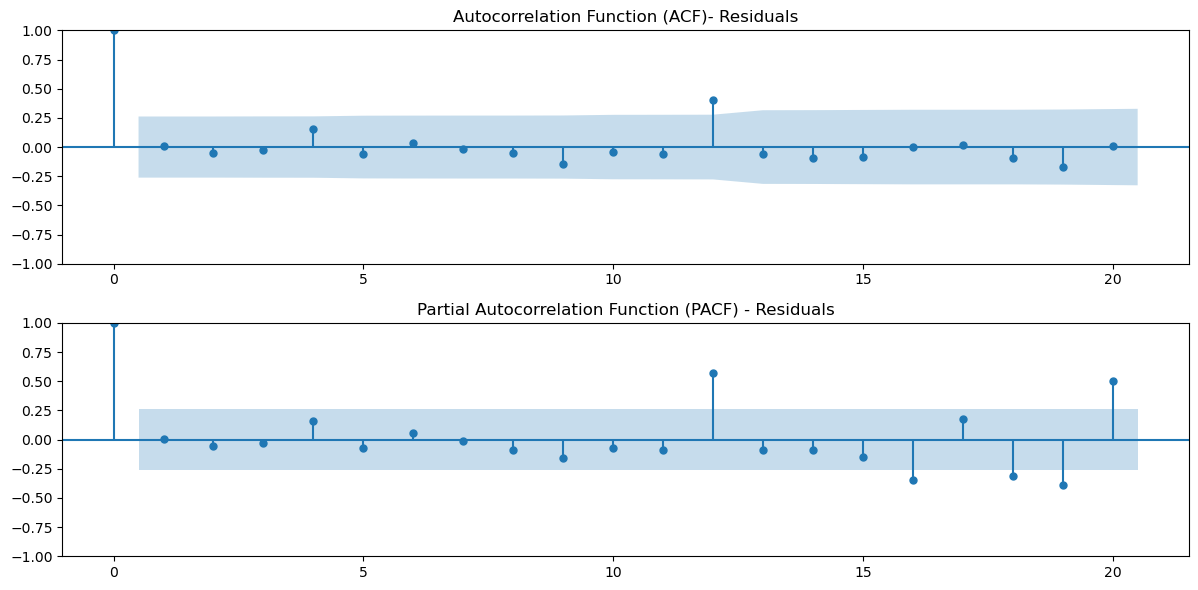

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

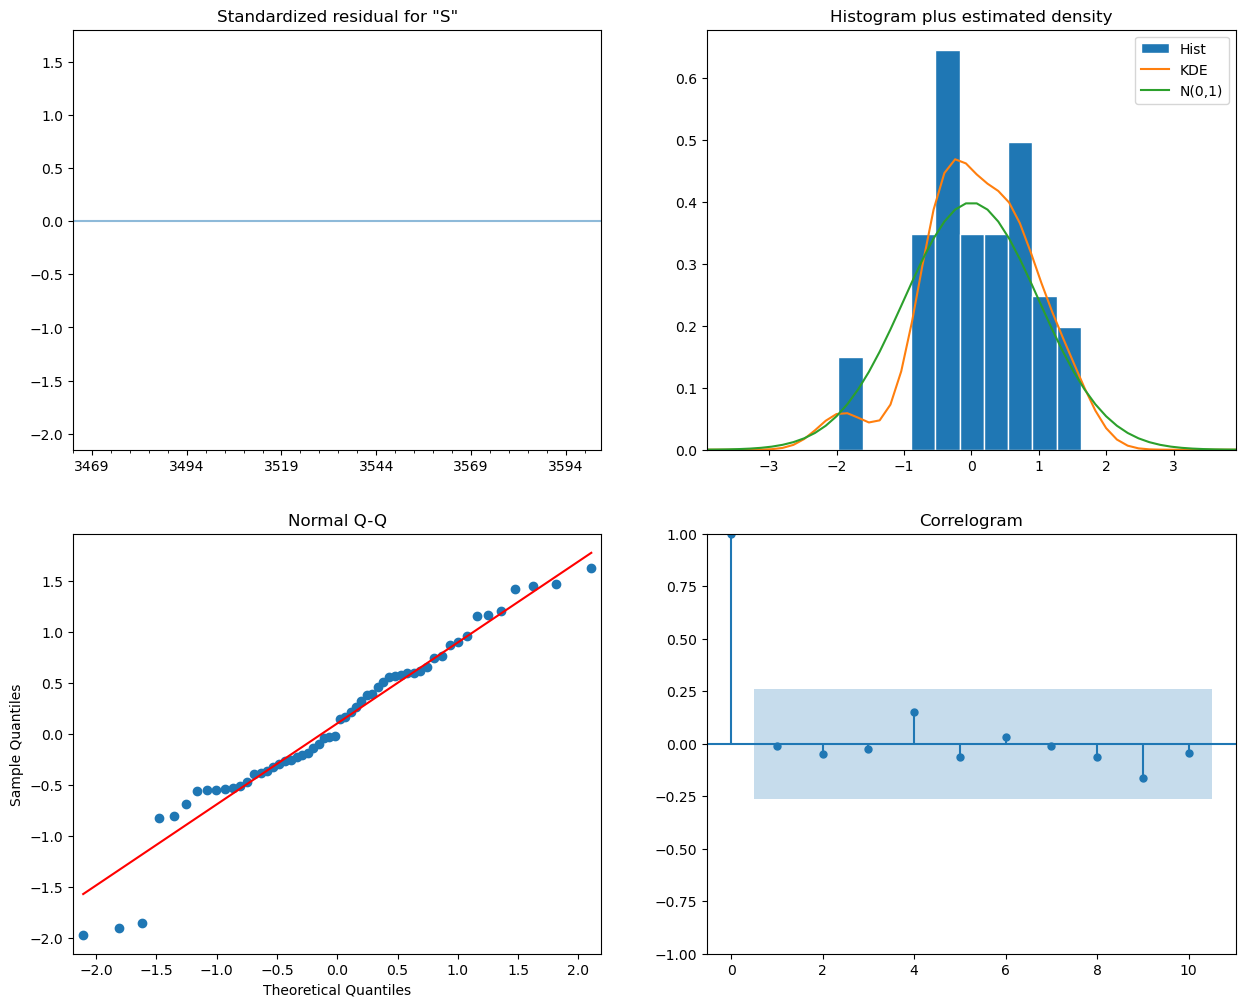

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_j['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_j.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_j)-1), dynamic = True)
sales_j['Forecast_ARIMA']=[None]*len(train) + list(pred)

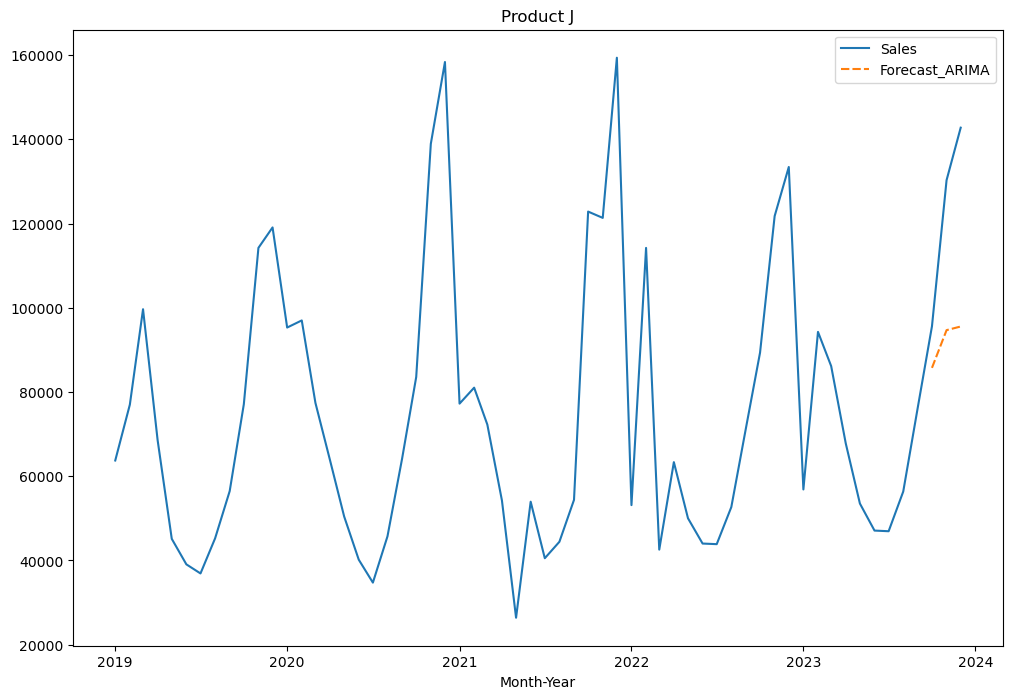

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j)
plt.title('Product J')
plt.show()

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 30900.230108033848
MAPE - ARIMA: 0.2357817537902498
MSE - ARIMA: 1198301190.9022298
RMSE - ARIMA: 34616.48726982895


# SARIMA

In [28]:
import statsmodels.api as sm

In [ ]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_j['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_j['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

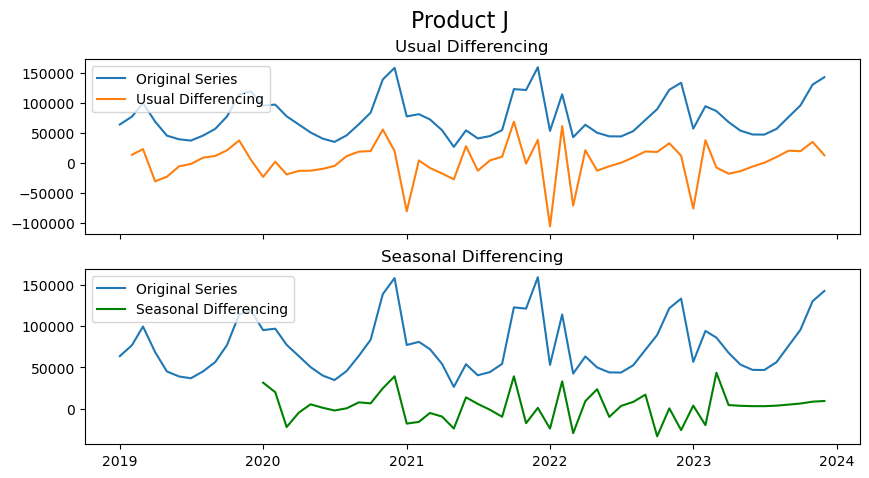

In [78]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_j['Sales'], label='Original Series')
axes[0].plot(sales_j['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_j['Sales'], label='Original Series')
axes[1].plot(sales_j['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product J', fontsize=16)
plt.show()

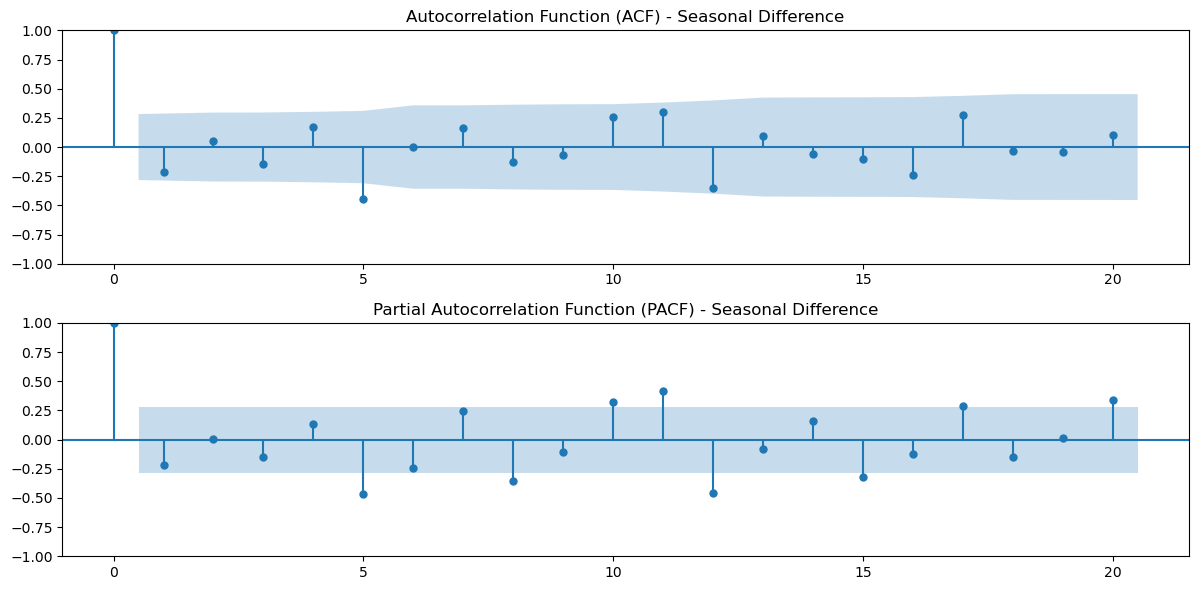

In [79]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_j['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_j['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

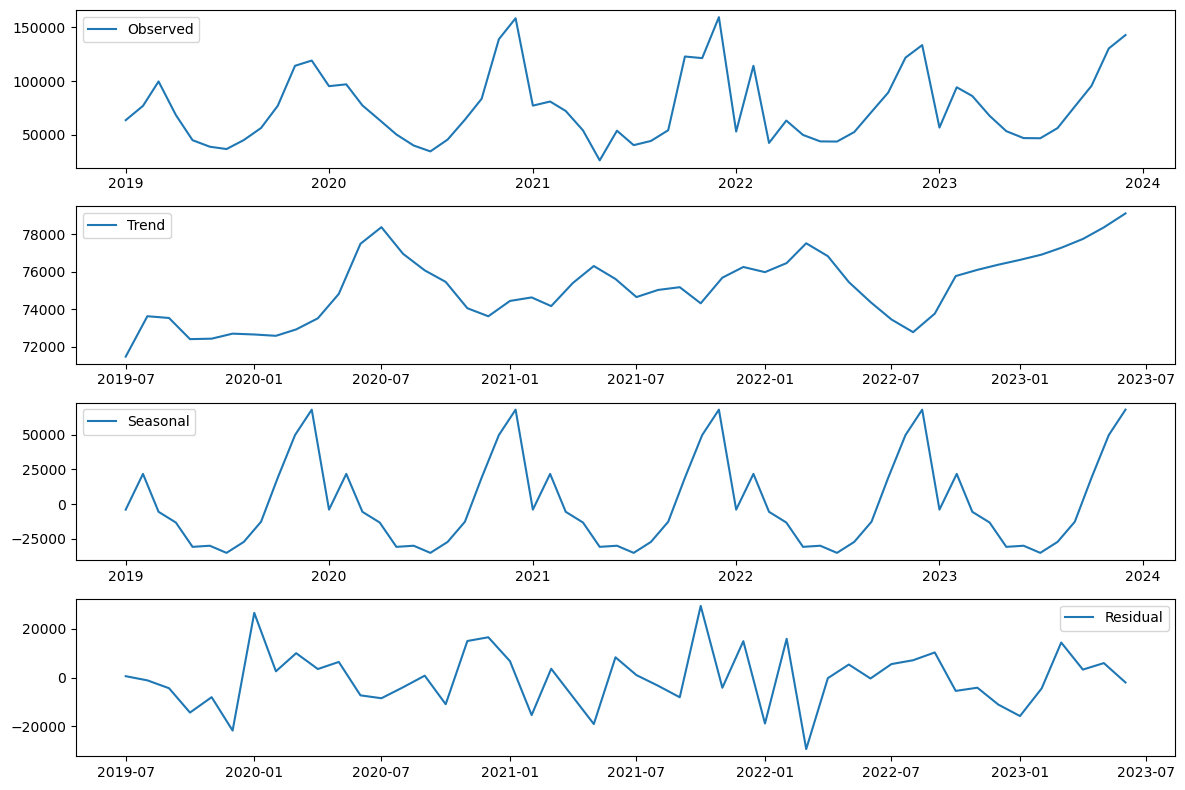

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_j['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [29]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(2):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(3, 1, 2), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=57, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [30]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q          aic          bic           mae           mse
6   3  0  1015.597827  1031.655534   5860.858377  4.638103e+07
0   0  0  1016.702818  1027.407956   4624.151706  2.375206e+07
8   4  0  1017.043649  1034.885546  16470.781966  3.493069e+08
7   3  1  1017.071092  1034.912989  14277.530438  2.712707e+08
1   0  1  1017.434430  1029.923757   6921.435804  6.792345e+07
5   2  1  1018.101617  1034.159324   7893.762142  8.683995e+07
3   1  1  1018.804524  1033.078041   5791.971868  5.202916e+07
2   1  0  1018.867782  1031.357110   3503.969834  2.080467e+07
9   4  1  1019.031781  1038.657867  16309.927916  3.435214e+08
10  5  0  1019.032593  1038.658679  16322.270376  3.439041e+08
4   2  0  1019.351386  1033.624903   3204.866767  1.363167e+07
11  5  1  1021.031892  1042.442167  16342.333145  3.447773e+08


In [31]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(3, 1, 2),seasonal_order=(3,1,0,12))
sarima_model=sarima.fit()

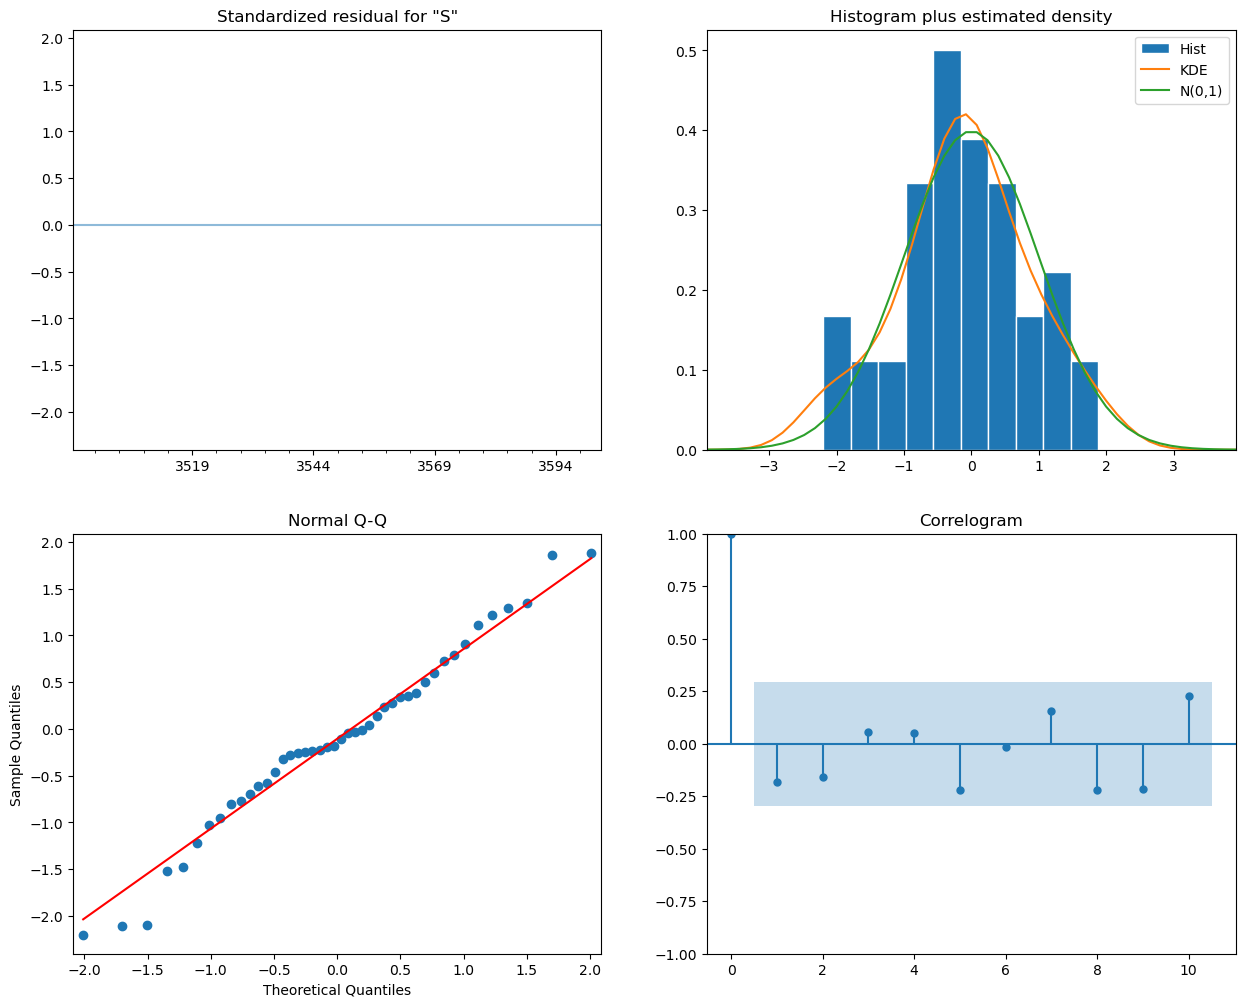

In [32]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [33]:
forecast_test_sarima=sarima_model.predict(start=57,end=59,dynamic=True)

In [34]:
sales_j['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product J')

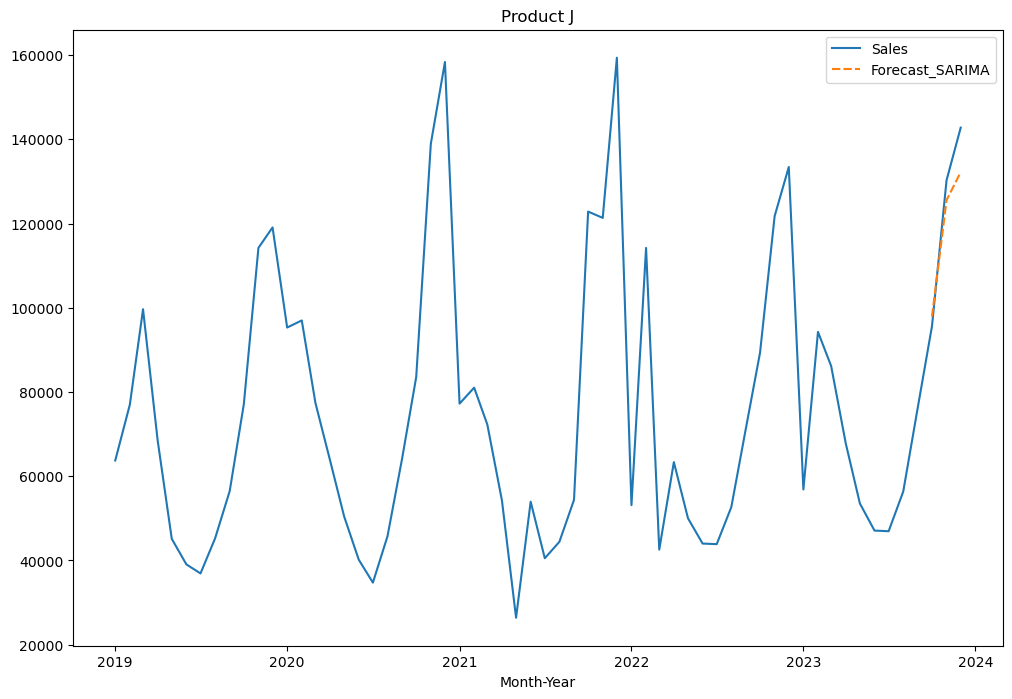

In [35]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j[['Sales','Forecast_SARIMA']])
plt.title('Product J')

In [36]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 5860.858
MAPE - SARIMA: 0.045
MSE - SARIMA: 46381031.98
RMSE - SARIMA: 6810.362


# AUTO-ARIMA

In [37]:
import pmdarima as pm

In [38]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=6 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1032.193, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1028.174, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1029.681, Time=0.22 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1028.680, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1031.123, Time=0.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1034.463, Time=0.33 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1031.924, Time=0.73 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=inf, Time=6.37 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=8.34 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=1032.812, Time=3.86 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=1031.263, Time=2.18 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=1033.029, Time=3.52 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1033.263, Time=5.24 sec
 ARIMA(0,1,1)(0

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [39]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   57
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -505.450
Date:                              Thu, 09 May 2024   AIC                           1016.899
Time:                                      19:04:34   BIC                           1022.252
Sample:                                  01-01-2019   HQIC                          1018.884
                                       - 09-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4713      0.097     -4.849      0.000      -0.662      -0.281
ma.S.L12      -0.2644      0.083     -3.202      0.001      -0.426      -0.103
sigma2      5.271e+08   2.72e-11   1.94e+19      0.000    5.27e+08    5.27e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.58   Prob(JB):                         0.56
Heteroskedasticity (H):               0.31   Skew:                            -0.32
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.22e+34. Standard errors may be unstable.
"""

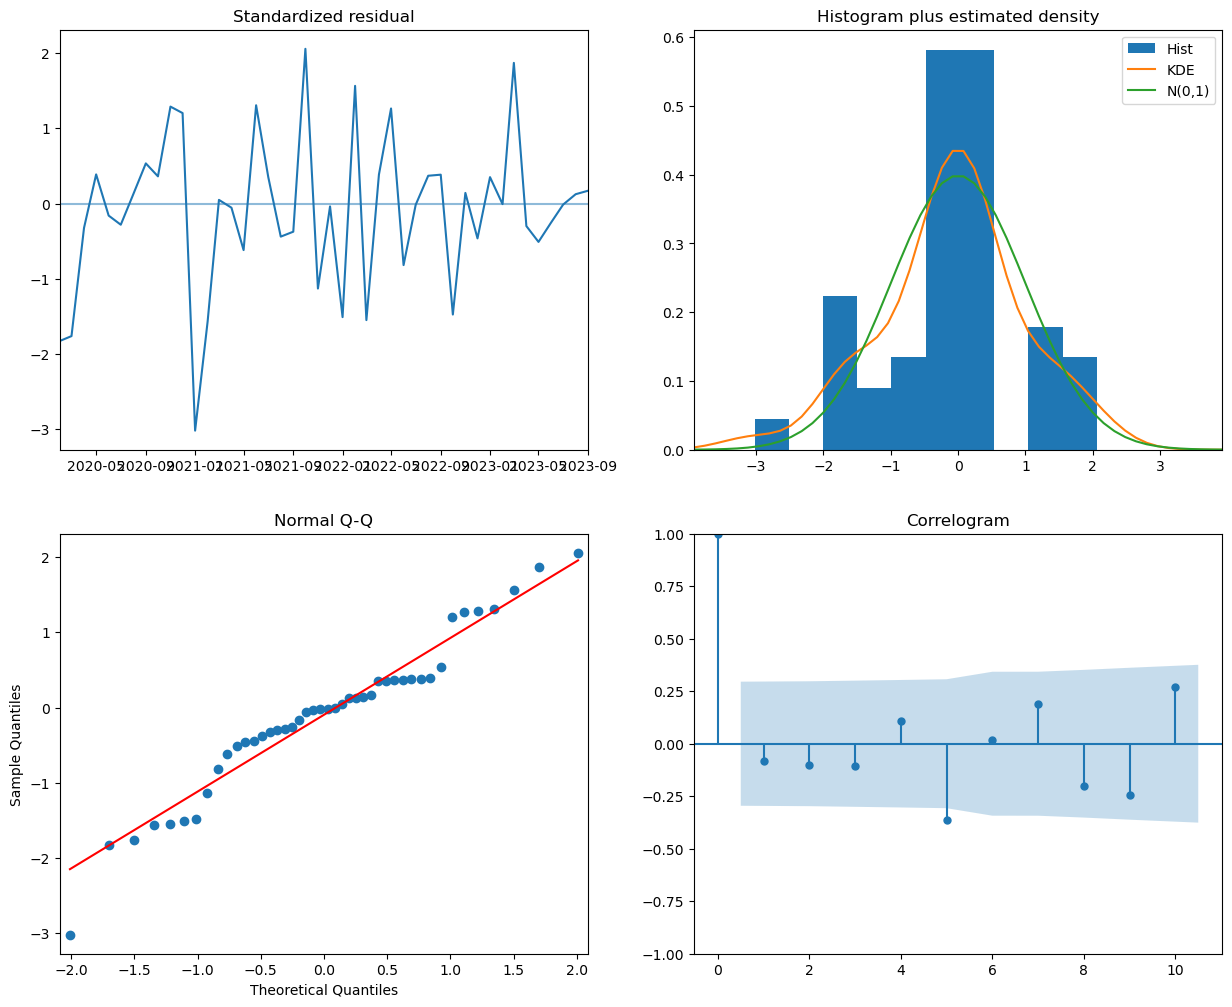

In [40]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [41]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_j['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_j.plot()

Text(0.5, 1.0, 'Product J')

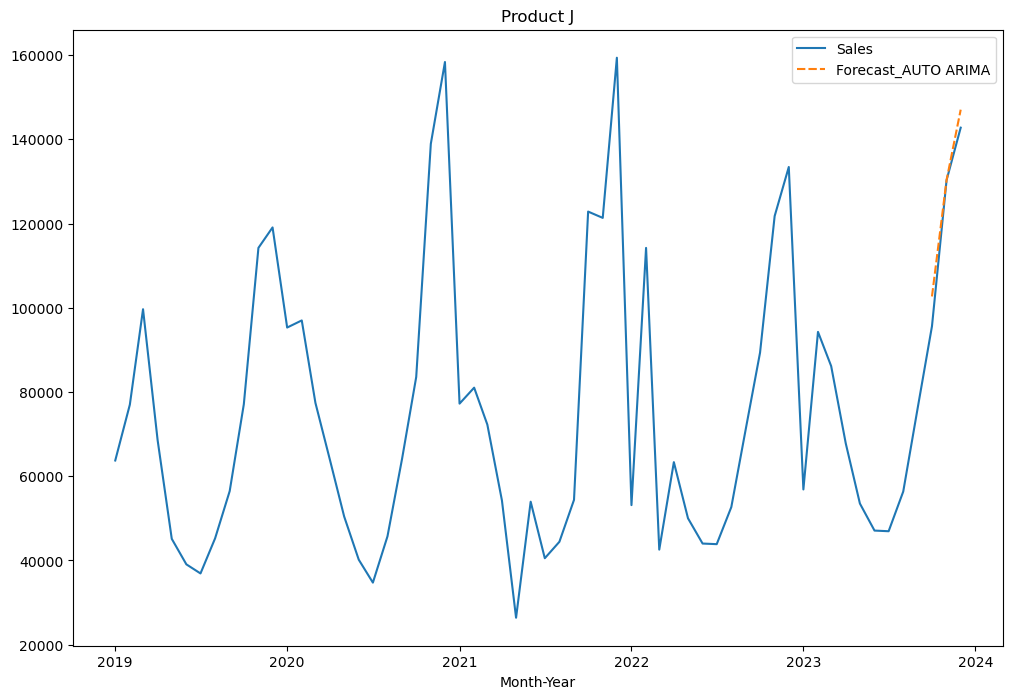

In [42]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product J')

In [43]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 3793.7855857507143
MAPE - AUTO ARIMA: 0.03473982478026489
MSE - AUTO ARIMA: 22817765.40330201
RMSE - AUTO ARIMA: 4776.794469443082


In [44]:
sales_j.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,56843,NaN,NaN,NaN
2023-02-01,94268,NaN,NaN,NaN
2023-03-01,86135,NaN,NaN,NaN
2023-04-01,67767,NaN,NaN,NaN
2023-05-01,53500,NaN,NaN,NaN
2023-06-01,47080,NaN,NaN,NaN
2023-07-01,46924,NaN,NaN,NaN
2023-08-01,56348,NaN,NaN,NaN
2023-09-01,76393,NaN,NaN,NaN


In [45]:
sales_j.mean()

Sales                   75549.283333
Forecast_ARIMA          91982.103225
Forecast_SARIMA        118544.680014
Forecast_AUTO ARIMA    126676.118919
dtype: float64

In [46]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,30900.230108,0.235782,1.198301e+09,34616.487270
AUTO ARIMA,3793.785586,0.034740,2.281777e+07,4776.794469
SEASONAL ARIMA,5860.858377,0.044746,4.638103e+07,6810.362103


# TESTING

In [17]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1015.852, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1017.530, Time=0.06 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=1018.601, Time=0.28 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1017.586, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1019.348, Time=0.19 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1018.340, Time=0.27 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=1018.727, Time=1.13 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1018.092, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1019.612, Time=0.24 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1020.661, Time=0.46 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1019.695, Time=0.13 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1021.413, Time=0.41 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [18]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   57
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -505.926
Date:                  Wed, 08 May 2024   AIC                           1015.852
Time:                          20:17:40   BIC                           1019.465
Sample:                      01-01-2019   HQIC                          1017.199
                           - 09-01-2023                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1950.3778   2821.278      0.691      0.489   -3579.225    7479.980
sigma2      3.411e+08   7.87e+07      4.336      0.000    1.87e+08    4.95e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.35   Jarque-Bera (JB):                 0.74
Prob(Q):                              0.13   Prob(JB):                         0.69
Heteroskedasticity (H):               0.99   Skew:                             0.29
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_j['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product J')

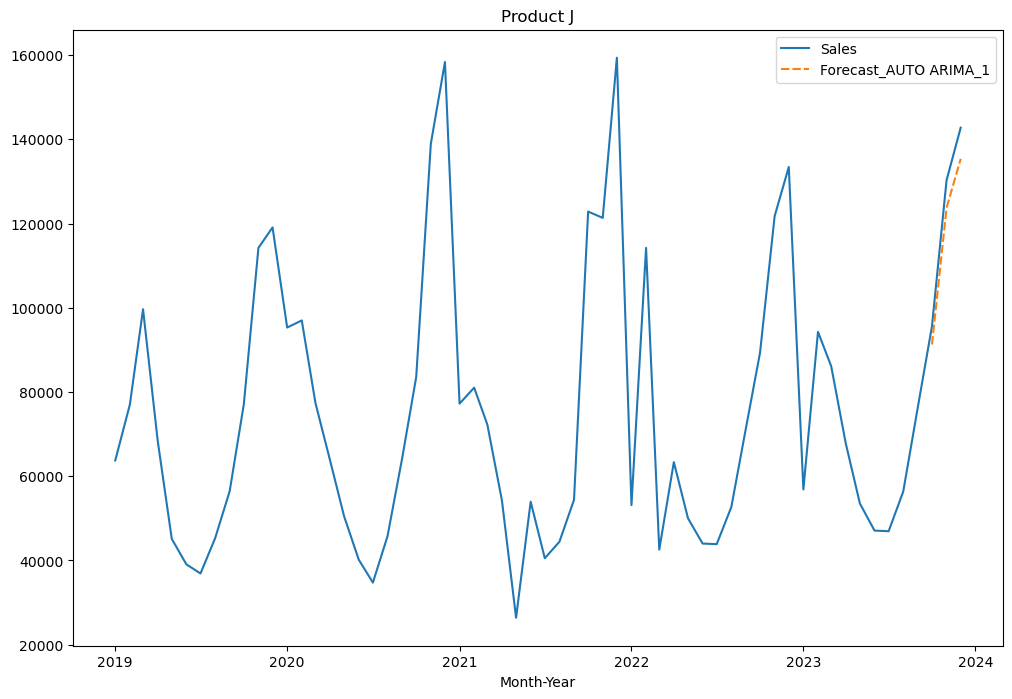

In [20]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product J')

In [21]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 6088.622222222223
MAPE - AUTO ARIMA: 0.049075653593841535
MSE - AUTO ARIMA: 38775681.231604934
RMSE - AUTO ARIMA: 6227.012223498918
